# Get Nbody Candidates

In [1]:
import rebound
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
%matplotlib inline

### Load data and stability predictions for System

In [20]:
system = "KOI-0168"    #KOI-0156, KOI-0168, KOI-2086

data = pd.read_csv("systems/%s_data.csv"%system)
results = pd.read_csv("systems/%s_results.csv"%system)
Ms = {}; Ms["KOI-0156"] = 0.56; Ms["KOI-0168"] = 1.11; Ms["KOI-2086"] = 1.04
epoch = 780

#get e
data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)

### Get Nbody candidates for Sunnyvale
Randomly sample from three stability probability ranges (low, medium, high).

In [21]:
N_samples = 201
random.seed(42)
#index = random.sample(results.index, N_samples)
i1 = random.sample(np.where((results["predict_proba"] > 0)&(results["predict_proba"] < 0.5))[0],N_samples/3)
i2 = random.sample(np.where((results["predict_proba"] > 0.5)&(results["predict_proba"] < 0.85))[0],N_samples/3)
i3 = random.sample(np.where((results["predict_proba"] > 0.85)&(results["predict_proba"] <= 1))[0],N_samples/3)
index = np.concatenate((i1,i2,i3))

In [22]:
data.loc[index].head()

,Unnamed: 0,m1,T1,P1,h1,k1,m2,T2,P2,h2,k2,m3,T3,P3,h3,k3,e1,e2,e3
1388,1388,1.631387,781.996132,7.107883,0.197022,0.094424,2.758778,786.046853,10.740921,0.136953,0.125074,2.294253,783.203327,15.275137,0.109259,0.115941,0.218480,0.185471,0.159310
44,44,6.633243,781.994457,7.107433,-0.058392,0.196863,13.896842,786.043699,10.741780,-0.051508,0.169513,1.222234,783.202160,15.279291,-0.042122,0.144628,0.205340,0.177166,0.150637
478,478,3.487838,781.996963,7.107740,0.052759,0.120598,5.958936,786.046247,10.741382,0.036441,0.118008,3.196742,783.201446,15.275182,0.050175,0.092988,0.131633,0.123506,0.105661
374,374,2.611293,782.009021,7.107214,0.133257,0.133186,3.281603,786.042472,10.739931,0.102289,0.133833,5.242902,783.203507,15.276750,0.068196,0.079958,0.188404,0.168447,0.105090
1518,1518,2.071923,781.992940,7.107993,0.194371,-0.001190,5.889316,786.041401,10.741461,0.150594,0.025721,3.830412,783.203025,15.274562,0.134596,0.029947,0.194374,0.152775,0.137887


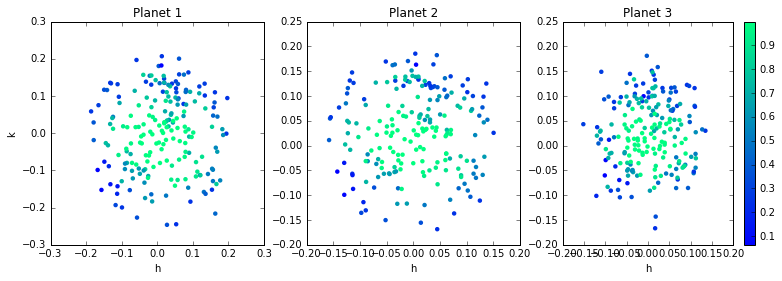

In [23]:
# Plot Nbody Candidates
x = "h"
y = "k"
proba = results["predict_proba"].loc[index].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x].loc[index], data["%s1"%y].loc[index], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x].loc[index], data["%s2"%y].loc[index], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x].loc[index], data["%s3"%y].loc[index], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s_Nbodycandidates.png"%(system,x,y))

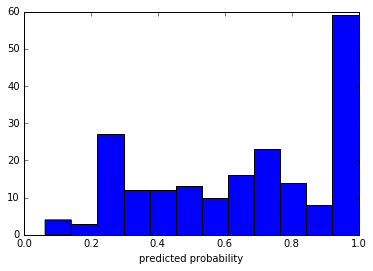

In [24]:
plt.hist(proba, 12);
plt.xlabel('predicted probability')

## Make Sunnyvale Jobs

In [5]:
norbits = 1e9            #number of orbits of innermost planet
dir = 'jobs/'

f2 = open("systems/%s_NbodyIDs.csv"%system,"w"); f2.write("Nbody IDs\n")
for shadow in [0,1]:
    for sample in data.loc[index].iterrows():
        id_ = sample[0]    #id number of sample
        job_name = "%s_1e%dorbits_id%d_shadow%d"%(system,int(np.log10(norbits)),id_,shadow)
        sh_script_name = "%s%s"%(dir,job_name)
        with open(sh_script_name, 'w') as f:
            f_head = open('job_header_sunnyvale','r')
            f.write(f_head.read())
            f_head.close()
            f.write('#PBS -N %s \n'%job_name)
            f.write('# EVERYTHING ABOVE THIS COMMENT IS NECESSARY, SHOULD ONLY CHANGE nodes,ppn,walltime and my_job_name VALUES\n')
            f.write('cd $PBS_O_WORKDIR\n')      #This will be the home stability_predict directory
            f.write('source ../venv/bin/activate \n')
            f.write('python run_Nbody.py %d %f %.2f %d %d %s >& batch.output\n'%(id_,Ms[system],epoch,norbits,shadow,job_name))
        f.close()
        if shadow == 0:
            f2.write("%d\n"%id_)
f2.close()